# Longevity and Disease model validation on UKBB data
##### requires Disease_Longevity_UKBB notebook to be preprocessed (for model scores)

In [42]:
source(here::here("code/init.R"))
source(here::here("code/ukbb_preprocessing.R"))
source(here::here("code/ukbb_outcome.R"))

### Loading scores

In [22]:
pop <- tgutil::fread(here::here('output/pop_scores.csv')) #see Disease_Longevity_UKBB notebook for computation

In [23]:
head(pop %>% select(-id))

,age,sex,longevity,longevity_q,diabetes,ckd,copd,cvd,liver
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,45,female,0.9675882,0.1925792,0.08815524,0.04167553,0.02798628,0.2060382,0.022592036
2,45,male,0.9119281,0.1060348,0.15909692,0.03919249,0.09064247,0.2944900,0.008487539
3,45,female,0.9969831,0.4574361,0.20979514,0.13855365,0.12811647,0.6370679,0.022256322
4,45,male,0.9945255,0.3984270,0.07791844,0.05965531,0.04335517,0.2117718,0.033393441
5,45,female,0.9838166,0.2651281,0.08008288,0.02218681,0.06593383,0.1207745,0.009952694
6,45,male,0.9377217,0.1345166,0.03196407,0.04930571,0.01263509,0.1157229,0.014305011


## 10-year survival by longevity score

In [24]:
demog <- tgutil::fread(here::here('output/ukbb_demog.csv'))

In [25]:
survival <- get_patients_survival(pop, demog)

In [26]:
pop_survival <- pop %>% left_join(survival, by=c("id", "sex", "age")) %>% 
    mutate(qbin=cut(longevity_q, seq(0, 1, by=0.1), right=FALSE, include.lowest=T))

In [27]:
km_10y_age_60 <- plyr::ddply(pop_survival %>% filter(age == 60), plyr::.(sex), function(x) 
{
    fit <- survminer::surv_fit(survival::Surv(follow_time, dead)~qbin, data=x)
    stats <- survminer::surv_summary(fit, x)
    stats_10y <- stats %>% mutate(t=floor(time/365)) %>% 
        distinct(t, strata, .keep_all=T) %>% 
        filter(t == 10) %>% 
        mutate(age=x$age[1])
    return(stats_10y)
}) %>% mutate(x=1-(as.numeric(qbin)-1)/length(levels(qbin)), 
              sex=factor(sex, levels=c('male', 'female')))
g <- ggplot(km_10y_age_60, aes(x=x, y=surv, ymax=upper, ymin=lower, colour=sex, group=sex)) + 
    geom_line() + 
    scale_colour_manual(values=c('#586c82', '#f6bfcb')) + 
    geom_errorbar(width=0.005) + 
    theme_bw() + 
    ylab('10 year survival') + 
    scale_x_continuous(breaks=seq(0, 1, by=0.2)) + 
    xlab('longevity score') + 
    theme(axis.text.x = element_text(angle=90, hjust=1, vjust=0.5))



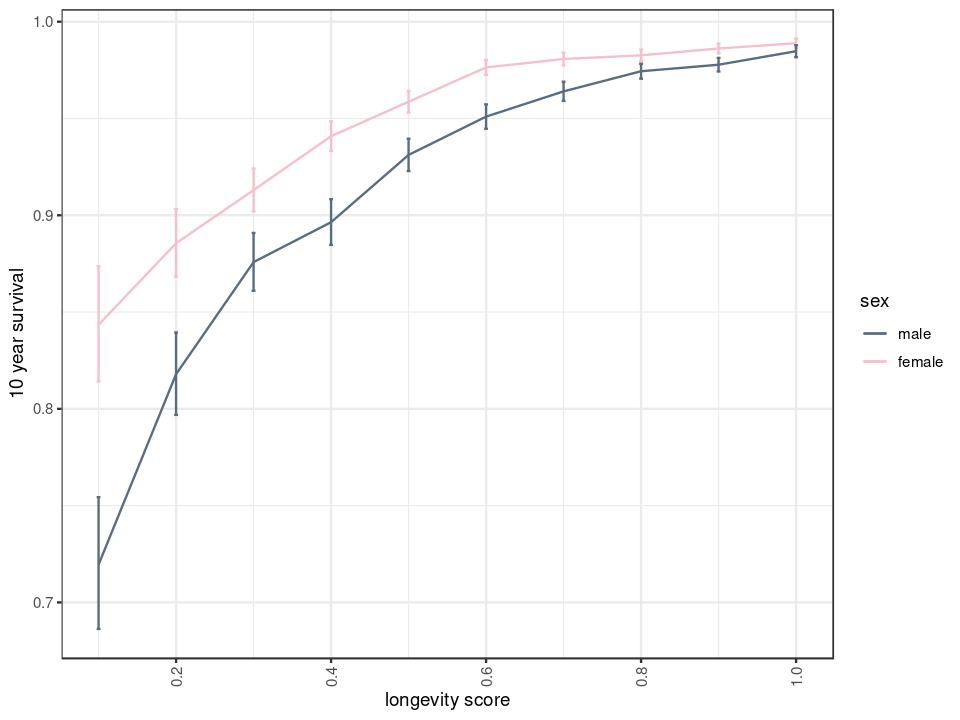

In [33]:
library(repr)
options(repr.plot.width=8, repr.plot.height=6)
g
#tgppt::plot_gg_ppt(g, out_ppt=here('figures/ukbb_longevity_10y_survival.pptx'), 
#    rasterize_plot=FALSE, top=1, left=1, width=6.4, height=4, overwrite=TRUE)

## 10-year disease outcome by disease score

In [34]:
diseases <- data.table::fread(here::here('output/ukbb_diseases.csv'))  #see Disease_Longevity_UKBB notebook for computation

In [35]:
disease_outcomes <- get_patients_disease_outcomes(survival, diseases)


In [36]:
names(disease_outcomes)

[1] "diabetes" "ckd"      "copd"     "cvd"      "liver"

In [37]:
km_disease_10y_60 <- purrr::map2_df(disease_outcomes, names(disease_outcomes), function(d, name) {
        data <- pop %>% filter(age == 60) %>% 
            select(id, age, sex, value=!!name) %>% left_join(d, by=c("id", "age", "sex")) %>% 
            mutate(obsT = ifelse(follow_time < disease_follow_time, follow_time, disease_follow_time), 
                status=ifelse(sick, 1, ifelse(dead, 2, 0)),
                qbin=cut(value, seq(0, 1, by=0.1), right=FALSE, include.lowest=T)) %>% 
            filter(!is.na(qbin)) # removing patients that were sick before lab tests, will have a missing score
        return(purrr::map_df(c('male', 'female'), function(s) {
            fit <- cmprsk::cuminc(data %>% filter(sex == s) %>% pull(obsT), 
                                   data %>% filter(sex == s) %>% pull(status), 
                                   data %>% filter(sex == s) %>% pull(qbin))
            fit_data <- purrr::map2_df(fit, names(fit), ~  as.data.frame(.x) %>% mutate(name=.y)) %>% 
                select(time, est, var, name) %>% filter(time>= 3650) %>% 
                distinct(name, .keep_all=TRUE) %>% 
                mutate(std=sqrt(var),
                    lower=est ^ exp(-qnorm(0.975) * sqrt(var)/(est*log(est))),
                    upper=est ^ exp(qnorm(0.975) * sqrt(var)/(est*log(est)))
                ) %>% 
                tidyr::separate(name, into=c('qbin', 'status'), sep=" ") %>% 
                filter(status == 1)
            return(fit_data %>% mutate(sex = s))
        }) %>% mutate(disease=name))
    }) %>% mutate(
        disease=factor(disease, levels=names(disease_outcomes)), 
        qbin=factor(qbin), 
        x=(as.numeric(qbin)-1)/length(levels(qbin)), 
        sex=factor(sex, levels=c('male', 'female')))


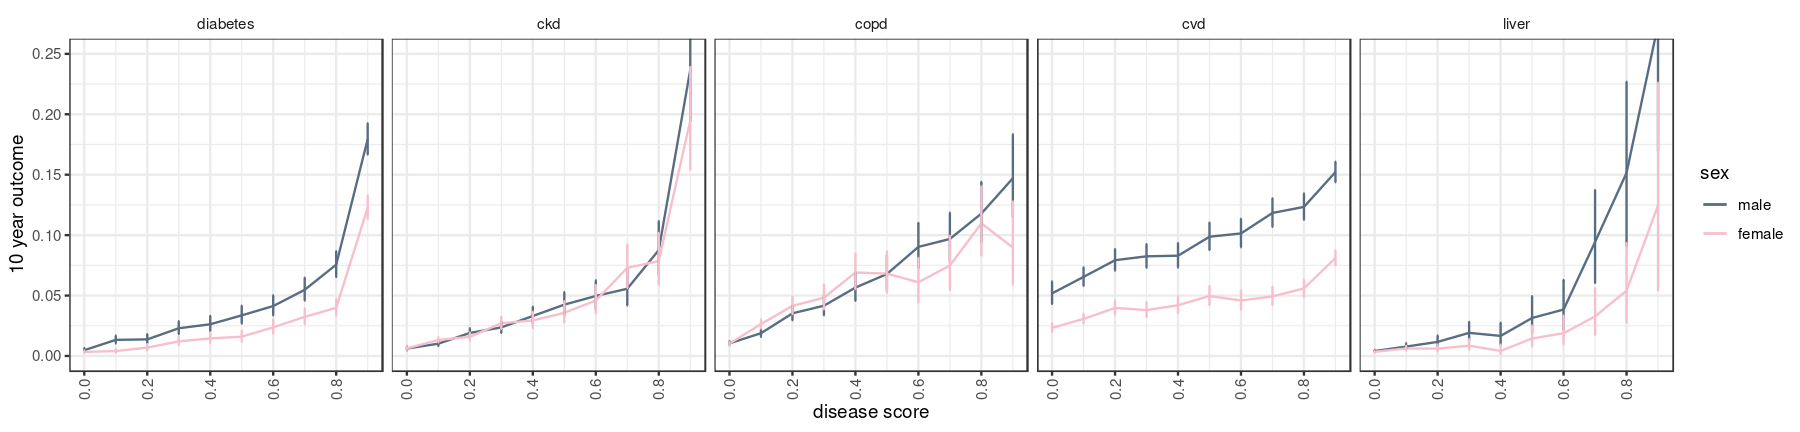

In [39]:
g <- ggplot(km_disease_10y_60, aes(x=x, y=est, ymax=upper, ymin=lower, colour=sex, group=sex)) + 
        geom_line() + 
        facet_grid(.~disease) + 
        scale_colour_manual(values=c('#586c82', '#f6bfcb')) + 
        geom_errorbar(width=0.005) + 
        theme_bw() + ylab('10 year outcome') + 
        scale_x_continuous(breaks=seq(0, 1, by=0.2)) + 
        xlab('disease score') + 
        coord_cartesian(ylim=c(0,0.25)) + 
        theme(axis.text.x = element_text(angle=90, hjust=1, vjust=0.5), strip.background = element_blank())
options(repr.plot.width=15, repr.plot.height=3.6)
g

In [41]:
#tgppt::plot_gg_ppt(g, out_ppt=here('figures/ukbb_disease_10y_outcome.pptx'), 
#        rasterize_plot=FALSE, top=1, left=1, width=13.3, height=4, overwrite=TRUE)